In [ ]:
!pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=59187551429d0808baf4805dafc7bcc22099b88e9ce96e1a06f2d08f41a6e4f6
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
# ============================================================
# 0. Imports e Configuração
# ============================================================
from datasets import load_dataset
import os
import re, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from lime.lime_text import LimeTextExplainer
import shap

from google.colab import drive
drive.mount('/content/drive_colab')

# Caminho do projeto no Drive
project_path = '/content/drive_colab/MyDrive/Colab Notebooks/TrabalhoFinal_TEP'

# Pasta para gráficos
graficos_path = os.path.join(project_path, 'graficos')
os.makedirs(graficos_path, exist_ok=True)
print(f"[INFO] Gráficos serão salvos em: {graficos_path}")


N_PER_CLASS = 2000
TOP_K = 20
MIN_DF = 5

Mounted at /content/drive_colab
[INFO] Gráficos serão salvos em: /content/drive_colab/MyDrive/Colab Notebooks/TrabalhoFinal_TEP/graficos


In [ ]:
# ============================================================
# 1. COLETA
# ============================================================
ds = load_dataset("sms_spam")
train = ds["train"]

# converter para formato IMDB-like
spam = [x["sms"] for x in train if x["label"] == 1][:N_PER_CLASS]
ham  = [x["sms"] for x in train if x["label"] == 0][:N_PER_CLASS]

textos = spam + ham
rotulos = ["spam"] * len(spam) + ["ham"] * len(ham)

print(f"[COLETA] SMS SPAM carregado. Total={len(textos)}, spam={len(spam)}, ham={len(ham)}")
print("\nExemplo de texto ORIGINAL:\n", textos[0][:200])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

[COLETA] SMS SPAM carregado. Total=2747, spam=747, ham=2000

Exemplo de texto ORIGINAL:
 Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



In [ ]:
# ============================================================
# 2. LIMPEZA
# ============================================================
def limpar(txt):
    t = txt.lower()
    t = unicodedata.normalize("NFKD", t).encode("ASCII", "ignore").decode("ASCII")
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"\d+", " ", t)
    t = re.sub(r"[^\w\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

textos_limpos = [limpar(t) for t in textos]

print("\n[LIMPEZA] Exemplo texto limpo:\n", textos_limpos[0][:200])



[LIMPEZA] Exemplo texto limpo:
 free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s


In [ ]:
# ============================================================
# 3. STOPWORDS
# ============================================================
stopwords_set = set(ENGLISH_STOP_WORDS)

# acrescentar termos comuns em SMS
custom_sw = {"u", "ur", "ok", "pls", "text", "msg", "call"}
stopwords_set |= custom_sw

stopwords_list = list(stopwords_set)

# contagem antes/depois
tokens_original = [w for txt in textos_limpos for w in txt.split() if w not in ENGLISH_STOP_WORDS]
tokens_new      = [w for txt in textos_limpos for w in txt.split() if w not in stopwords_set]

cont_original = Counter(tokens_original).most_common(TOP_K)
cont_new      = Counter(tokens_new).most_common(TOP_K)

# plot 1 (salvar)
plt.figure(figsize=(10,4))
plt.bar([t for t,_ in cont_original], [c for _,c in cont_original])
plt.xticks(rotation=90)
plt.title("Top K termos antes das novas stopwords")
plt.tight_layout()
plt.savefig(f"{graficos_path}/topk_antes_stopwords.png")
plt.close()

# plot 2 (salvar)
plt.figure(figsize=(10,4))
plt.bar([t for t,_ in cont_new], [c for _,c in cont_new])
plt.xticks(rotation=90)
plt.title("Top K termos depois das novas stopwords")
plt.tight_layout()
plt.savefig(f"{graficos_path}/topk_depois_stopwords.png")
plt.close()


In [ ]:
# ============================================================
# 4. VETORIZAÇÃO
# ============================================================
bow_vec = CountVectorizer(stop_words=stopwords_list, min_df=MIN_DF)
tfidf_vec = TfidfVectorizer(stop_words=stopwords_list, min_df=MIN_DF)

X_bow = bow_vec.fit_transform(textos_limpos)
X_tfidf = tfidf_vec.fit_transform(textos_limpos)

vocab_bow = np.array(bow_vec.get_feature_names_out())
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

print("\n[MATRIZES]")
print("  BoW:", X_bow.shape)
print("  TF-IDF:", X_tfidf.shape)



[MATRIZES]
  BoW: (2747, 936)
  TF-IDF: (2747, 936)


In [ ]:
# ============================================================
# 5. GRÁFICOS DE PESO DE TERMOS
# ============================================================

# BOW
bow_counts = np.asarray(X_bow.sum(axis=0)).ravel()
df_bow = pd.DataFrame({"termo": vocab_bow, "peso": bow_counts})
df_bow_top = df_bow.sort_values("peso", ascending=False).head(TOP_K)

plt.figure(figsize=(10,4))
plt.bar(df_bow_top["termo"], df_bow_top["peso"])
plt.xticks(rotation=90)
plt.title("BoW – Termos mais frequentes")
plt.tight_layout()
plt.savefig(f"{graficos_path}/bow_topk.png")
plt.close()

# TF-IDF
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).ravel()
df_tfidf = pd.DataFrame({"termo": vocab_tfidf, "peso": tfidf_means})
df_tfidf_top = df_tfidf.sort_values("peso", ascending=False).head(TOP_K)

plt.figure(figsize=(10,4))
plt.bar(df_tfidf_top["termo"], df_tfidf_top["peso"])
plt.xticks(rotation=90)
plt.title("TF-IDF – Termos mais importantes")
plt.tight_layout()
plt.savefig(f"{graficos_path}/tfidf_topk.png")
plt.close()


In [ ]:
# ============================================================
# 6. TREINAMENTO
# ============================================================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

SEED = 42
y = np.array(rotulos)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=SEED, stratify=y
)

modelo = LogisticRegression(max_iter=300, random_state=SEED)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)


[DADOS] Treino: (2197, 936) Teste: (550, 936)

[MÉTRICAS]
Accuracy : 0.9509090909090909
Precision: 0.992
Recall   : 0.8266666666666667
F1-score : 0.9018181818181819

[CLASSIFICATION REPORT]
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       400
        spam       0.99      0.83      0.90       150

    accuracy                           0.95       550
   macro avg       0.97      0.91      0.93       550
weighted avg       0.95      0.95      0.95       550



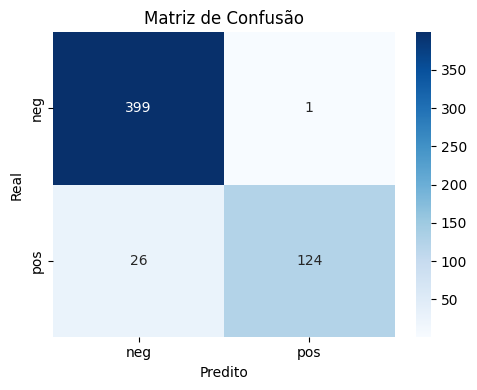

In [ ]:
# ============================================================
# 7. MÉTRICAS
# ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Escolha qual representação usar:
# X = X_bow
X = X_tfidf
y = np.array(rotulos)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("[DADOS] Treino:", X_train.shape, "Teste:", X_test.shape)

# Modelo linear (ótimo para textos)
modelo = LogisticRegression(max_iter=300)
modelo.fit(X_train, y_train)

# Predições
y_pred = modelo.predict(X_test)

# Métricas
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label="spam")
rec  = recall_score(y_test, y_pred, pos_label="spam")
f1   = f1_score(y_test, y_pred, pos_label="spam")

print("\n[MÉTRICAS]")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

print("\n[CLASSIFICATION REPORT]")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg", "pos"],
            yticklabels=["neg", "pos"])
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 8.1. LIME – 3 explicações
# ============================================================
explainer = LimeTextExplainer(class_names=["ham", "spam"], random_state=SEED)
predict_fn = lambda texts: modelo.predict_proba(tfidf_vec.transform(texts))

indices = [10, 50, 120]

for i in indices:
    exp = explainer.explain_instance(textos_limpos[i], predict_fn, num_features=10)
    fig = exp.as_pyplot_figure()
    fig.savefig(f"{graficos_path}/lime_exemplo_{i}.png")
    plt.close()


In [ ]:
# ============================================================
# 8.2. SHAP – local e global (corrigido e compatível com savefig)
# ============================================================
explainer_shap = shap.LinearExplainer(modelo, X_tfidf, feature_perturbation="interventional")
shap_values_array = explainer_shap.shap_values(X_tfidf)

# Criar Explanation
shap_values = shap.Explanation(
    values=shap_values_array,
    base_values=explainer_shap.expected_value,
    data=X_tfidf.toarray(),
    feature_names=vocab_tfidf
)

# Função para garantir que o SHAP desenhe no Matplotlib
def start_shap_plot():
    plt.figure(figsize=(9,6))

# 3 exemplos locais
for i in indices:
    start_shap_plot()
    shap.plots.bar(shap.Explanation(
        values=shap_values.values[i],
        base_values=shap_values.base_values,
        data=shap_values.data[i],
        feature_names=shap_values.feature_names
    ), show=False)

    plt.tight_layout()
    plt.savefig(f"{graficos_path}/shap_local_{i}.png")
    plt.close()

# summary plot (global)
start_shap_plot()
shap.summary_plot(
    shap_values,
    features=X_tfidf.toarray(),
    feature_names=vocab_tfidf,
    show=False
)

plt.tight_layout()
plt.savefig(f"{graficos_path}/shap_global_summary.png")
plt.close()


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
